/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


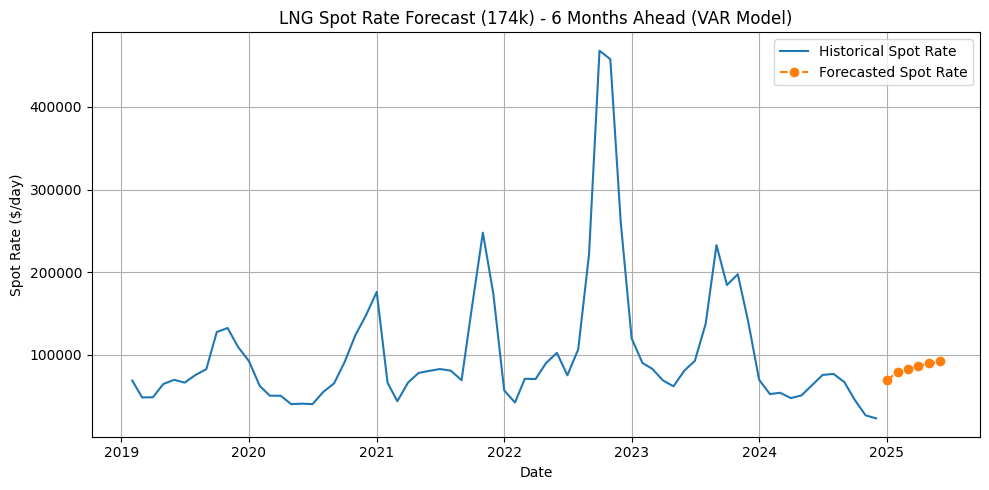

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# STEP 1: Load and clean the data
df = pd.read_csv("datatest_3.csv")
df.columns = df.columns.str.strip().str.replace('\n', ' ')
df["Date"] = pd.to_datetime(df["Date"], format="%b-%Y", errors='coerce')
df = df.set_index("Date").sort_index()

# STEP 2: Select relevant variables
var_df = df[[
    "LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)",
    "LNG Capacity (CBM)",
    "Spread ASIA-US", "Spread EU-US", "Spread ASIA-EU"
]].dropna()
var_df.columns = ["SpotRate_174k", "LNG_Capacity", "Spread_Asia_US", "Spread_EU_US", "Spread_Asia_EU"]

# STEP 3: Check stationarity and difference non-stationary series
def adf_test(series):
    result = adfuller(series.dropna(), autolag="AIC")
    return result[1]  # p-value

if adf_test(var_df["LNG_Capacity"]) > 0.05:
    var_df["LNG_Capacity"] = var_df["LNG_Capacity"].diff()
if adf_test(var_df["Spread_Asia_US"]) > 0.05:
    var_df["Spread_Asia_US"] = var_df["Spread_Asia_US"].diff()
if adf_test(var_df["Spread_EU_US"]) > 0.05:
    var_df["Spread_EU_US"] = var_df["Spread_EU_US"].diff()

# Drop NA from differencing
var_df = var_df.dropna()

# STEP 4: Fit VAR model
model = VAR(var_df)
results = model.fit(maxlags=4, ic='aic')

# STEP 5: Forecast 6 months ahead (assuming monthly frequency)
forecast_steps = 6
forecast = results.forecast(var_df.values[-results.k_ar:], steps=forecast_steps)
forecast_index = pd.date_range(start=var_df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=var_df.columns)

# STEP 6: Plot the spot rate forecast
plt.figure(figsize=(10, 5))
plt.plot(var_df["SpotRate_174k"], label="Historical Spot Rate")
plt.plot(forecast_df["SpotRate_174k"], label="Forecasted Spot Rate", marker='o', linestyle='--')
plt.title("LNG Spot Rate Forecast (174k) - 6 Months Ahead (VAR Model)")
plt.xlabel("Date")
plt.ylabel("Spot Rate ($/day)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
